### Library imports

In [1]:
%matplotlib inline
# package for scientific computing with Python
import numpy as np
# Data structure and data analysis tool
import pandas as pd

# sklearn is machine learning library for the Python
from sklearn import preprocessing
# K-means clustering algo
from sklearn.cluster import KMeans
# Support vector machine library
from sklearn import svm
# Principal component analysis (PCA) module
from sklearn.decomposition import PCA

#OS moduled for file oprations
import os
#CSV module
import csv
# Data plotting libraries
import matplotlib.pyplot as plt
# File operation libraries
import shutil
import glob
# Math functions
import math

### Declare and define file/folders for storing/retrieving data for analysis

In [2]:
#Base Folder Paths
base_folder_name = 'converted'
test_folder_name = 'test2'
base_path = os.path.join(base_folder_name, test_folder_name)
#Normal Sample and cluster paths
sample_dir_name = 'samp'
sample_path = os.path.join(base_path, sample_dir_name)
#If sample folder exist
if os.path.isdir(sample_path):
    #Test and Train data Folders
    sample_train_path = os.path.join(base_path, sample_dir_name+'_train')
    os.makedirs(sample_train_path, exist_ok=True)
    sample_test_path = os.path.join(base_path, sample_dir_name+'_test')
    os.makedirs(sample_test_path, exist_ok=True)
    #Clustering folders
    cluster_train_path = os.path.join(sample_train_path, 'cluster')
    os.makedirs(cluster_train_path, exist_ok=True)
    cluster_test_path = os.path.join(sample_test_path, 'cluster')
    os.makedirs(cluster_test_path, exist_ok=True)  

### Defining features we want to work with

In [3]:
features = [1, 6, 17] #(ICMP:1, TCP:6, UDP:17)  

In [4]:
def filter_ip(df, ip_addr):
    """
    Take out ip adress that you dont want to see in trainng data
    
    Parameters
    ----------
    
    df: panda dataframe
        table from which processing has to be done.
    ip_addr: string
        IP address to be removed from table.
    """
    with open(os.path.join(base_path,"filtered_ip_feture_vector"), "a+") as f:
        df.loc[ip_addr].to_csv(f, header=False)
    df = df.drop([ip_addr])
    return df    

### Creating feature tables which would be input to k-means learning algorithms

In [5]:
def get_feature_dataframe(sample_file, features):
    """
    Create feature table from the sample file which has flow information
    
    Parameters
    ----------
    
    sample_file: string
        file(full path) containing IP layer information destination address, 
        protocol, time stamp.
        
    features: list
        list of feature we required for anlysis.
    """
    df = pd.read_csv(sample_file, index_col=0)
    #Filter Columns
    df = df[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
    #Remove null destinations
    df = df[df['ip.dst'].notnull()]
    #Rename Columns
    df.columns = ['ip', 'protocol', 'time_stamp', 'sample']
    #Get count for each ip
    df = df.groupby(['ip', 'protocol']).size().unstack().fillna(0).astype(int)
    #Drop row for given IP
    #df = filter_ip(df, '147.32.84.165')        
    if(set(df.columns) != set(features)):
        non_columns = set(features) - set(df.columns)
        for c in non_columns:
            df.insert(loc=features.index(c), column=c, value=0)
    #Select only required protocols which would be used as features
    df = df[features]
    return df

In [6]:
filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
df = get_feature_dataframe(filenames[0], features)

In [7]:
df.head()

protocol,1,6,17
ip,,,
104.107.0.221,0,21,0
104.107.1.225,0,340,0
104.107.30.247,0,59,0
104.107.6.192,0,321,0
104.107.6.212,0,55,0


In [8]:
#Merge sample files to create bigger sameple
def merge_files(files, merge_count, features):
    """
    Merge feature sample file to form bigger samples.
    
    Parameters
    ----------
    files: list
        all the sample files,
    
    merge_count: int
        number of files to be merged.
    
    features: list
        list of features
    
    """
    if len(files) < merge_count:
        print('Too few file to merge')
        return
    dfs = []
    count = 0
    for file in files:
        if count == 0:
            df = get_feature_dataframe(file, features)
            count += 1
        else:
            temp_df = get_feature_dataframe(file, features)
            df = df.append(temp_df)
            count += 1
        if count == merge_count:
            df = df.groupby(df.index).sum()
            dfs.append(df)
            count = 0
    return dfs

In [9]:
def create_train_test(sample_path, features, merge_count=1):
    """
    Seperate data into train and test for the evaluation of the algorithms
    
    Parameters
    ----------
    
    sample_path: string
        location where all the packet sample files are kept
    
    merge_count: int, default 1
        Number of files to be merged to create a feature table
        
    feature: list
        List of features to be considered for creating feature table
    """
    files = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
    
    test_files = files[:merge_count]
    train_files = files[merge_count:]
    
    test_dfs = merge_files(test_files, merge_count, features)
    train_dfs = merge_files(train_files, merge_count, features)
    
    return train_dfs, test_dfs, merge_count

#### Create train and test data frames

In [10]:
train_dfs, test_dfs, merge_count = create_train_test(sample_path, features)

In [11]:
train_dfs[0].head()

protocol,1,6,17
ip,,,
104.107.0.221,0,18,0
104.107.1.225,0,5,0
104.107.30.247,0,6,0
104.107.6.212,0,4,0
104.16.230.152,0,14,0


#### Save merge count which will be used for merging the files to form larger sample.

In [12]:
np.savetxt(os.path.join(base_path, 'merge_count'), 
           np.asarray(merge_count).reshape(1,), fmt='%d')

#### Store train and test tables on the file system

In [13]:
#Write train and test data to file
train_files = []
for i, df in enumerate(train_dfs, 1):
    train_file = os.path.join(sample_train_path,str(i))
    df.to_csv(train_file)
    train_files.append(train_file)
test_files = []    
for i, df in enumerate(test_dfs, 1):
    test_file = os.path.join(sample_test_path,str(i))
    df.to_csv(test_file)
    test_files.append(test_file)

## k-means Clustering

### Functions for finding optimal number of clusters for k-means clustering algorithm using elbow method.

In [14]:
#Find optimal number of clusters for k-means clustering using elbow method.
def elbow_method(X_trans, ax, title):
    """
    For the k-means algorithm, elbow method check the percent of 
    variance explained as function of the number of clusters. 
    Variance for each cluster number is calculated and the cluster 
    number which produce less variance for the next cluster number 
    is selected as best choice.
    
    Parameters
    ----------
    
    X_tran: vector
        Standardize vector.
    """
    elbow_count = 0
    range_val = 10
    nc = range(1, range_val)
    kmeans = [KMeans(n_clusters=i) for i in nc]
    score = [kmeans[i].fit(X_trans).score(X_trans) for i in range(len(kmeans))]
    total_diff = abs(score[0] - score[len(score) -1])
    for i in range(range_val - 2):
        percent_diff = abs(score[i] - score[i+1])/total_diff
        if percent_diff < 0.01:
            opt_clust_count = i
            break
    ax.plot(nc,score)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Score')
    ax.set_title(title)
    return opt_clust_count

In [15]:
def get_optimal_cluster_count(df_list, count):
    """
    Apply elbow method on all the sample vectors and get their mean as 
    the best cluster number for kmeans algorithm.
    
    Parameters
    ----------
    
    df_list: list of dataframes
        contain tables/dataframes for each sample data.
        
    count: int
        Number of sample to loop t.
    """
    elbow_vals = []
    row_count = math.ceil(count/2)
    fig = plt.figure(figsize=(10, 4*row_count), dpi=80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=.5) #Adjust space between the subplot
    for i, df in enumerate(df_list[:count], 1):
        X = df.values
        #Create scaling and transforme
        X_trans = preprocessing.StandardScaler().fit_transform(X)
        #Create subplot
        ax = fig.add_subplot(row_count, 2, i)
        title = 'Sample:'+str(i)
        fig.suptitle('Elbow Method', fontsize=16)
        elbow = elbow_method(X_trans, ax, title)
        elbow_vals.append(elbow)
    plt.savefig('elbow-method.png')
    return int(np.floor(np.mean(elbow_vals)))

#### Get the optimal cluster count

In [16]:
sample_count = 4 #Number of samples to be used for elbow method

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


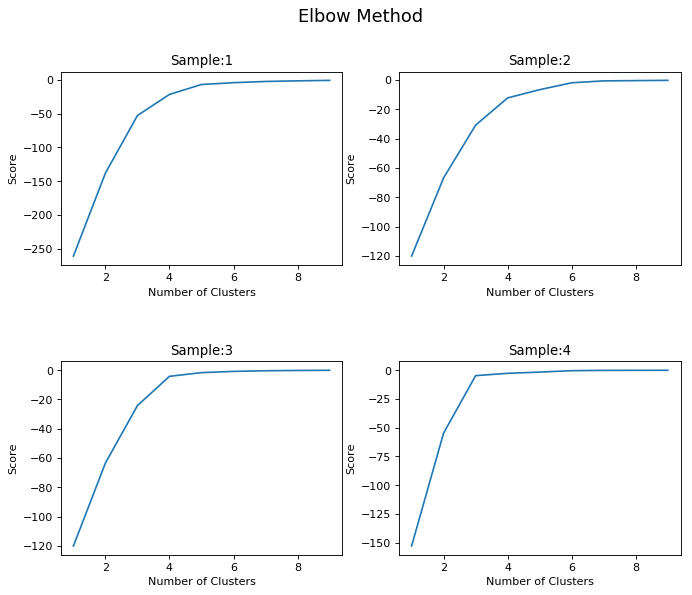

In [17]:
cluster_count = get_optimal_cluster_count(train_dfs, sample_count)

In [18]:
cluster_count

4

### Functions for finding and storing the centroid which would be used for all k-means clustering.

In [19]:
def get_kmeans_centroid(feature_df, cluster_count):
    """ 
    Run the k-means algorithm on input data vector and find out the 
    centroid for each cluster then return that centroid in the
    form of table
    
    Parameters
    ----------
    
    feature_df: table/dataframe
        vector on which the k-means algorithm is be applied
        
    cluster_count: int
        Number of clusters to be used for k-means clustering
    """
    df_centroid = {}
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Training data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(X_trans)
    #Create cluster data-frame for saving on file system
    #Dataframe 0 contain all the clusters centers associated with 0th cluster
    first = True
    for i in range(kmeans.cluster_centers_.shape[0]):
        s = pd.Series(kmeans.cluster_centers_[i], index=feature_df.columns)
        if(first):
            df_centroid = pd.DataFrame(columns=feature_df.columns)
            first = False
        df_centroid = df_centroid.append(s,ignore_index=True)
    return df_centroid

In [20]:
def get_kmeans_cluster_centroids(sample_frames, features, cluster_count):
    """
    This function will first find all cluster centroids for all the 
    training sample vectors and then calculate the median of each 
    cluster over all the samples. This median would be the best guess 
    of the centroid for all the training vectors and also would be use
    for evaluation.
    
    Parameters
    ----------
    
    sample_frames: list
        list of feature vector datafames.
        
    features: list
        list of feature.
        
    cluster_count: int
        number of clusters to be considered for k-means clustering.
        
    """
    df_concat = pd.DataFrame(columns=features)
    for df in sample_frames:
        #Run kmeans and get centroid
        df_centroid = get_kmeans_centroid(df, cluster_count)
        #Create list of centroids
        df_concat = df_concat.append(df_centroid)
    centroids = []
    #Find median for each centroid and store them in file
    for c in range(cluster_count):
        med = np.median(df_concat.loc[c], axis=0) # e.g. df_concat.loc[0] is df of clister 0
        centroids.append(med)
    return centroids

#### Find the median of all the centroid which will be better estimate of the centroid for all future k-means clustering and store it on the file system. Also store the feature list on file system:

In [21]:
#Already define base directory path
base_path = base_path
#File to store centroids
centroid_filename = 'centroids.csv'
#File to store feature list
features_filename = 'features.csv'

#Call to find median of centroid
centroids = get_kmeans_cluster_centroids(train_dfs, features, cluster_count)

#Save centroids and features in files for future use
np.savetxt(os.path.join(base_path, centroid_filename), 
           np.asarray(centroids), delimiter=",")
np.savetxt(os.path.join(base_path, features_filename), 
           np.asarray(list(features)), delimiter=",")

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### After finding cluster count and the common centroids we will be doing kmeans clustering using previously calculated centroids

In [22]:
def read_centroid_features(base_path, centroid_filename, features_filename):
    """
    Read previously calculated centroids and stored feature from the file system.
    
    Parameters
    ----------
    
    base_path: string
        folder location in which both controid and feature file are present
    
    centroid_filename: string
        Name of the file in which centroid vector is stored.
        
    features_filename: string
        Name of the file in which feature list is stored.
    
    """
    centroids = np.genfromtxt(os.path.join(base_path,centroid_filename), delimiter=',')
    features = np.genfromtxt(os.path.join(base_path,features_filename), delimiter=',')
    features = list(features.astype('int64'))
    return centroids, features        

In [23]:
#Base directory path
base_path = base_path #Already define
#File to store centroids
centroid_filename = centroid_filename #Already define
#File to store feature list
features_filename = features_filename #Already define
#Get centroids and feature
centroids, features = read_centroid_features(base_path, 
                                             centroid_filename, features_filename)

In [24]:
def draw_clusters(X, pre_centroids, ax, title):
    """
    Draw clusters in 2D
    
    Parameters
    ----------
    
    X: vector
        vector to be clustered and plot.
    
    ax: object
        pyplot subplot object for ploting the clusters.
    
    title: string
        title of the plot.    
    
    """
    if X.shape[1] > 2:
        #Use PCA component analysis for 2D visuals
        reduced_X = PCA(n_components=2).fit_transform(X)
        km = KMeans(n_clusters=pre_centroids.shape[0])
        km.fit(reduced_X)
    else:
        reduced_X = X
        km = KMeans(n_clusters=pre_centroids.shape[0], init=pre_centroids)
        km.fit(reduced_X)
   
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 0].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')   
    
    #Plot the data points 
    ax.plot(reduced_X[:,0],reduced_X[:,1],  'k.', markersize=3)
    # Plot the centroids as a white X
    centroids = km.cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, 
               linewidths=3, color='w', zorder=10)
    #Set tile and boundaries of the plot
    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

### Plot k-means clustering for samples

In [25]:
def plot_kmeans_clusters(to_print_df):
    fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    row_count = math.ceil(len(to_print_df)/2)
    for i, df in enumerate(to_print_df, 1):
        X = df.values
        #Create scaling
        X_trans = preprocessing.StandardScaler().fit_transform(X)
        #Create subplot
        ax = fig.add_subplot(row_count, 2, i)
        plt.suptitle('k-means++ clustering (with PCA-reduced data)', fontsize=16)
        title = 'Sample:'+str(i)
        draw_clusters(X_trans, centroids, ax, title)
    plt.savefig('kemans-clustering.png') 

#### Plot only few clusters as not all required.

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


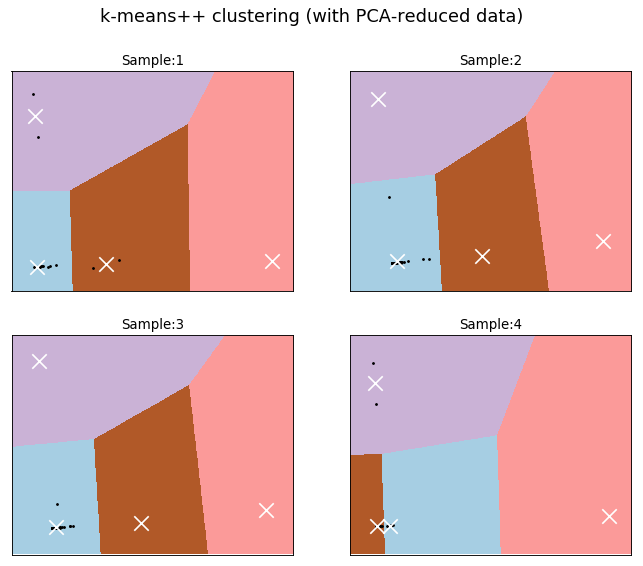

In [26]:
plot_count = 4
to_print_df = train_dfs[:plot_count]
plot_kmeans_clusters(to_print_df)

### Do k-means++ clustering and save clustered output in the files

In [27]:
def kmeans_clustering(feature_df, centroids):
    """
    Clustering input vector using k-means algorithm
    
    Parameter
    ---------
    feature_df: Object
        Panda dataframe object containing input vector which
        is to clustered using k-means.
        
    centroids: vector
        Vector containing centroid values. These centroids are
        used for clutering.
    
    """
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Training data
    X_trans = scaler.transform(X)
    #k means clustering using provided centroids 
    kmeans = KMeans(n_clusters=centroids.shape[0], init=centroids)
    clusters = kmeans.fit_predict(X_trans)
    #Getting the labels/clusters for each IP
    cluster_df = pd.DataFrame({'cluster': kmeans.labels_})
    #Attaching labels to existing dataframe and return new dataframe
    df = pd.concat([feature_df.reset_index(), cluster_df], axis=1).set_index('ip')
    return df

### Apply Clustering on both training data and test data. Store clustered information on the file system

In [28]:
#First retrieve the centroids and features
centroids, features = read_centroid_features(base_path, centroid_filename, features_filename)

#### Cluster all the samples and store them on file.

In [29]:
centroids, features = read_centroid_features(base_path, centroid_filename, features_filename)
for i, train_df in enumerate(train_dfs):
    clustered_df = kmeans_clustering(train_df, centroids)
    clustered_df.to_csv(os.path.join(cluster_train_path,str(i+1)))
for i, test_df in enumerate(test_dfs): 
    clustered_df = kmeans_clustering(test_df, centroids)
    clustered_df.to_csv(os.path.join(cluster_test_path,str(i+1)))    

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [30]:
print(centroids)

[[-0.16666667 -0.1530641  -0.19014421]
 [-0.19991842  5.09967417  5.50771871]
 [ 5.52647412 -0.27596259 -0.15599916]
 [-0.19002385 -0.31990378  0.015432  ]]


### Now combine clustering of all the train/test samples and find out the best cluster and average packet count for each IP 

In [31]:
def get_best_cluster_sample_count(cluster_path):
    """
    Get all the trained IP address and then combine training data
    from all the sample to make best judgment about the cluster
    in which IP address should be placed into. It also gives the
    average number of packets flowing during the analysis time
    which would help to determine if its truly attack or
    just a misjudgment.
    
    Parameters
    ----------
    
    cluster_path: string
        directory location where the clustered samples are stored.
    
    """
    files = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for file in files:
        if first:
            df = pd.read_csv(file, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(file, index_col=0)
            df = df.append(temp_df) 
    #Fist reindex all data with IP
    df = df.reset_index().set_index(['ip'])
    
    new_columns =  ['cluster', 'packet_count']
    features = list(df.columns[:-1])
    cluster_column = list(df.columns[-1:])
    #Average packet count across all the samples
    packet_count = df[features].groupby('ip').mean().sum(axis=1).astype('int64')
    #most occuring cluster across all samples
    cluster = df[cluster_column].groupby('ip').median().astype('int64')
    #Create new dataframe with cluster and packet count and return new table/dataframe
    new_df = pd.concat([cluster, packet_count], axis=1)
    new_df.columns = new_columns
    return new_df

#### Get tables containing best judged cluster and average packet count

In [32]:
train_df = get_best_cluster_sample_count(cluster_train_path)
test_df = get_best_cluster_sample_count(cluster_test_path)

In [33]:
train_df.shape, test_df.shape

((209, 2), (161, 2))

### Function for finding RI index

In [34]:
import numpy as np
from scipy.misc import comb

def get_rand_index_score(train_df, test_df):
    r = pd.merge(train_df, test_df, left_index=True, right_index=True, how='right')
    r = r.dropna()
    r = r.astype(int)
    actual_clusters = r.iloc[:,0].tolist()
    predicted_clusters = r.iloc[:,1].tolist()    
    
    tp_plus_fp = comb(np.bincount(actual_clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(predicted_clusters), 2).sum()
    A = np.c_[(actual_clusters, predicted_clusters)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(actual_clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    ri =  (tp + tn) / (tp + fp + fn + tn)
    return ri

#### Find the RI index of the clustering using the train and test comparison

In [35]:
get_rand_index_score(train_df, test_df)

0.26153846153846155

#### Save the table obtained in previous step to file system. This table would be used to compare each flow with the past to identify if its threat or not.

In [36]:
#Save train result to file
train_tag_filename = 'ip_cluster_tag_train'
tag_file = os.path.join(base_path,train_tag_filename)
train_df.to_csv(tag_file)
#Save test result to file
test_tag_filename = 'ip_cluster_tag_test'
tag_file = os.path.join(base_path,test_tag_filename)
test_df.to_csv(tag_file)

## Anamoly Detection Using One Class SVM

In [37]:
#Create feature vector corrosponding to each cluster. 
#This feature vector would be used to define boundray using One Class SVM for the cluster.
def get_clusters_feature_vectors(cluster_path):
    cluster_dict = dict()
    filenames = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for filename in filenames:
        if first:
            df = pd.read_csv(filename, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df) 
            #print(df)
            break
    df = df.reset_index().set_index(['cluster','ip'])
    clusters = df.index.get_level_values(0).unique()
    for c in clusters:
        cluster_dict[c] = df.loc[c].values
    return cluster_dict

In [38]:
def plot_outlier_detecton(X, ax, title):
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
    else:
        reduced_X = X
    
    clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
    clf.fit(reduced_X)
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))

    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.set_title(title)
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

    s = 40
    b1 = ax.scatter(reduced_X[:, 0], reduced_X[:, 1], c='white', s=s, edgecolors='k')
    #ax.set_axis('tight')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    ax.legend([a.collections[0], b1],
           ["learned frontier", "training observations"],
           loc="upper left")

#### Get cluster data for training One Class SVM model

In [39]:
cluster_feature_dict = get_clusters_feature_vectors(cluster_train_path)

In [40]:
#cluster_feature_dict[2]

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


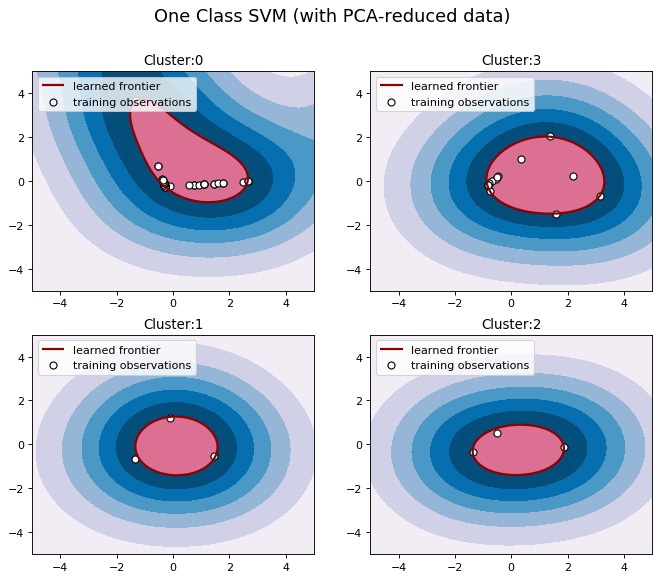

In [41]:
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
row_count = math.ceil(len(cluster_feature_dict)/2)
for i, (cluster, X) in enumerate(cluster_feature_dict.items(), 1):
    #Create scaling
    X_trans = preprocessing.StandardScaler().fit_transform(X)
    ax = fig.add_subplot(row_count, 2, i)
    plt.suptitle('One Class SVM (with PCA-reduced data)', fontsize=16)
    title = 'Cluster:'+str(cluster)
    if (X_trans.shape[0] >= X_trans.shape[1]):
        plot_outlier_detecton(X_trans, ax, title)
plt.savefig('one-class-SVM.png')

In [42]:
def one_class_svm(feature_vector, cluster):
    X_train = feature_vector
    #Get scaler
    scaler = preprocessing.StandardScaler().fit(X_train)
    #Transform Traning data
    X_trans = scaler.transform(X_train)
    # fit the model
    clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
    clf.fit(X_trans)
    clf.name = 'svm'
    return clf, scaler

In [43]:
cluster_train_path

'converted/test2/samp_train/cluster'

In [44]:
clf_dict = dict()
scaler_dict = dict()
for cluster, df in cluster_feature_dict.items():
    clf_dict[cluster], scaler_dict[cluster] = one_class_svm(df, cluster)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [45]:
#Predict for the give destination if it is normal or not
X_test = [[0,658,0]]#[[1491,18]]
X_test_tran = scaler_dict[0].transform(X_test)
clf_dict[0].predict(X_test_tran)

array([-1])

In [46]:
#plot_outlier_detecton(X_test_tran, clf_dict[0], 'test')

## Clustering the data captures during attack

In [55]:
#Already define base directory path
base_path = base_path
#File to store centroids
centroid_filename = 'centroids.csv'
#File to store feature list
features_filename = 'features.csv'

In [56]:
attack_sample_dir_name = 'attack_samp'
attack_sample_path = os.path.join(base_path, attack_sample_dir_name)
attack_sample_train_path = os.path.join(base_path, attack_sample_dir_name+'_train')
os.makedirs(attack_sample_train_path, exist_ok=True)
attack_cluster_path = os.path.join(attack_sample_train_path, 'cluster')
os.makedirs(attack_cluster_path, exist_ok=True)

In [57]:
files = sorted(glob.glob(os.path.join(attack_sample_path,'*')),  key=os.path.getmtime)
merge_count = np.genfromtxt(os.path.join(base_path,'merge_count'))

In [58]:
files

['converted/test2/attack_samp/1']

In [59]:
int(merge_count)

1

In [60]:
#Get centroids and feature list
centroids, features = read_centroid_features(base_path, centroid_filename, features_filename)

In [61]:
attack_dfs = merge_files(files, merge_count, features)

In [62]:
#Cluster all the samples and store them
for i, attack_df in enumerate(attack_dfs):
    clustered_df = kmeans_clustering(attack_df, centroids)
    clustered_df.to_csv(os.path.join(attack_cluster_path,str(i+1)))

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [63]:
#Read clustered attack file
files = sorted(glob.glob(os.path.join(attack_cluster_path,'*')),  key=os.path.getmtime)
df = pd.read_csv(files[0], index_col=0)

In [64]:
df.shape

(26, 4)

In [65]:
df.head()

,1,6,17,cluster
ip,,,,
104.208.156.39,0,2,0,3
172.217.10.109,0,1,0,3
172.217.10.110,0,1,0,3
172.217.10.14,0,0,4,3
172.217.10.227,0,0,6,3


In [66]:
train_tag_filename = 'ip_cluster_tag_train'
train_tag_file = os.path.join(base_path,train_tag_filename)
train_df = pd.read_csv(train_tag_file, index_col=0)

In [67]:
train_df.head()

,cluster,packet_count
ip,,
103.20.94.1,0,22
104.106.251.5,0,7
104.106.252.58,0,337
104.107.0.221,0,18
104.107.1.225,0,5


In [68]:
bad_ip_df = pd.DataFrame(columns=['ip', 'packet_count', 'cluster'])
for ip, row in df.iterrows():
    feature_row = row[:-1]
    cluster_value = row[-1]
    #cluster test
    if ip in train_df.index:
        packet_count = feature_row.sum()
        train_cluster = train_df.loc[ip]['cluster']
        #Compare each ip data with the train cluster 
        if(cluster_value == train_cluster):
            #SVM test: Check if its inside the boundary using one class svm
            X_test_tran = scaler_dict[cluster_value].transform([feature_row.values])
            prediction = clf_dict[cluster_value].predict(X_test_tran)
            if prediction == - 1:
                s = pd.Series([ip, packet_count, cluster_value], index=bad_ip_df.columns)
                bad_ip_df = bad_ip_df.append(s, ignore_index=True)
        else:
            s = pd.Series([ip, packet_count, cluster_value], index=bad_ip_df.columns)
            bad_ip_df = bad_ip_df.append(s, ignore_index=True)
            
bad_ip_df = bad_ip_df.set_index('ip')
print(bad_ip_df)

               packet_count cluster
ip                                 
104.208.156.39            2       3
172.217.10.110            1       3
172.217.10.14             4       3
172.217.10.227            6       3
172.217.10.234            1       3
172.217.10.238            1       3
172.217.12.174            8       3
172.217.9.238             4       3
173.194.68.189            2       3
192.168.0.4              31       2
192.168.0.7           29867       1
224.0.0.251               9       3
65.19.96.252              2       3
65.19.96.253              4       3
65.52.108.76              2       3


In [ ]:
def ddos_attack_candidate(bad_ip_df, ):
    